In [184]:
import numpy as np 
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.dates as mdates
import datetime
from sklearn.metrics import mean_squared_error


In [162]:
df = pd.read_csv('coin_Cardano.csv',header=0, parse_dates=[0])

In [163]:
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Cardano,ADA,2017-10-02 23:59:59,0.030088,0.019969,0.024607,0.025932,57641300.0,6.288991e+08
1,2,Cardano,ADA,2017-10-03 23:59:59,0.027425,0.020690,0.025757,0.020816,16997800.0,5.396927e+08
2,3,Cardano,ADA,2017-10-04 23:59:59,0.022806,0.020864,0.020864,0.021931,9000050.0,5.686195e+08
3,4,Cardano,ADA,2017-10-05 23:59:59,0.022154,0.020859,0.021951,0.021489,5562510.0,5.571390e+08
4,5,Cardano,ADA,2017-10-06 23:59:59,0.021542,0.018360,0.021359,0.018539,7780710.0,4.806646e+08


In [164]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [165]:
df = df[['Close']]

In [166]:
df.head()

,Close
Date,
2017-10-02 23:59:59,0.025932
2017-10-03 23:59:59,0.020816
2017-10-04 23:59:59,0.021931
2017-10-05 23:59:59,0.021489
2017-10-06 23:59:59,0.018539


In [167]:
# a variablle for predicting 'n' days out into the future
forecast_out = 2 
#create another column (the target) shifted 'n' units up 
df['Prediction'] = df['Close'].shift(-forecast_out)
print(df.tail())

                        Close  Prediction
Date                                     
2021-02-23 23:59:59  0.954709    1.079116
2021-02-24 23:59:59  1.051657    1.241105
2021-02-25 23:59:59  1.079116    1.324860
2021-02-26 23:59:59  1.241105         NaN
2021-02-27 23:59:59  1.324860         NaN


In [193]:
#creating the independend data set (X)
#convert dataframe to a numpy array
X = np.array(df.drop(['Prediction'],1))
#remove last '2' rows
X = X[:-forecast_out]
print(X)

[[0.0259318 ]
 [0.0208158 ]
 [0.0219315 ]
 ...
 [0.95470914]
 [1.05165663]
 [1.0791162 ]]


In [194]:
#create the dependent data set (y)
y = np.array(df['Prediction'])
y = y[:-forecast_out]
print(y)

[0.0219315  0.0214887  0.0185391  ... 1.0791162  1.24110539 1.32486029]


In [195]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [196]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [197]:
lr_confidence = lr.score(x_test, y_test)
print('lr_confidence: ', lr_confidence )

lr_confidence:  0.9727939773460534


In [198]:
# set x_forecast equal to the last 2 rows of the original data set from Close column
x_forecast = np.array(df.drop(['Prediction'],1))[-forecast_out:]
print(x_forecast)

[[1.24110539]
 [1.32486029]]


In [199]:
# print lr model prediction for the next 2 days
lr_prediction = lr.predict(x_forecast)
print(lr_prediction)

[1.25469306 1.33935069]


In [200]:
df.head()

,Close,Prediction
Date,,
2017-10-02 23:59:59,0.025932,0.021931
2017-10-03 23:59:59,0.020816,0.021489
2017-10-04 23:59:59,0.021931,0.018539
2017-10-05 23:59:59,0.021489,0.020941
2017-10-06 23:59:59,0.018539,0.020477


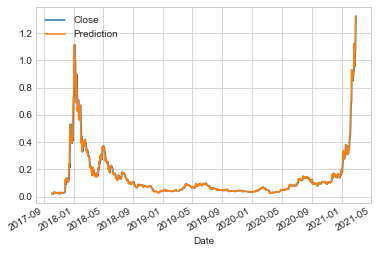

In [201]:
df.plot()

In [206]:
def ma21(crypto):
    return crypto.Close.rolling(21).mean()

In [207]:
df['MACD'] = df.Close.ewm(span=12, adjust=False).mean() - df.Close.ewm(span=26, adjust=False).mean()
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MA21'] = ma21(df)
df['Upper_band'], df['Lower_band'] = bollinger_bands(df)
df.dropna(inplace=True)

In [208]:
def trading_history(stock, net, std=2):    
    
    # Bollinger band plot with EMA and original historical data
    plt.figure(figsize=(16,5))
    plt.style.use('seaborn-whitegrid')
    plt.plot(stock.index, stock.Close, color='#3388cf', label='Price')
    plt.plot(stock.index, stock.MA21, color='#ad6eff', label='Moving Average (21 days)')
    plt.plot(stock.index, stock.Upper_band, color='#ffbd74', alpha=0.3)
    plt.plot(stock.index, stock.Lower_band, color='#ffa33f', alpha=0.3)
    plt.fill_between(stock.index, stock.Upper_band, stock.Lower_band, color='#ffa33f', alpha=0.1, label='Bollinger Band ({} STD)'.format(std))
    
    plt.title('Trading History', fontSize=15)
    plt.ylabel('Price', fontSize=12)
    plt.xlim([stock.index.min(), stock.index.max()])
    
    for i in net:
        if i[2] == 1: color = '#ff005e'
        else: color = '#4bd81d'
        plt.plot_date(i[0], i[1], color=color)
        
    plt.plot_date([],[],label='Buy', c='#ff005e')
    plt.plot_date([],[],label='Sell', c='#4bd81d')
        
    plt.legend(frameon=True, loc=1, ncol=1, fontsize=10, borderpad=.6)
    plt.show()

In [209]:
def macd_trading(stock, budget=15000, show_graph=True, show_return=True):
    
    state_check = lambda x, y: 1 if x > y else 0
    stock = stock.reset_index()    
    money = budget
    prev_state = state_check(stock.loc[0].MACD, stock.loc[0].Signal)
    stock_amt = 0
    net = []

    for i in range(1, len(stock)):

        today = stock.iloc[i]
        state = state_check(today.MACD, today.Signal)

        if state != prev_state:

            # BUY
            if (today.MACD > today.Signal) and (money != 0):
                stock_amt = int(money / today.Close)
                money = 0
                net.append([today.Date, today.Close, 1, stock_amt * today.Close])

            # SELL
            if (today.MACD < today.Signal) and (stock_amt != 0):
                money = stock_amt * today.Close
                stock_amt = 0
                net.append([today.Date, today.Close, 0, money])

        prev_state = state
    
    profit = net[-1][3] - budget
    
    if show_return == True:
        print('Number of Trades: {}'.format(len(net)))
        print('Time Frame: {} days'.format((net[-1][0] - net[0][0]).days))
        print('Profit: ${:.2f} | {}%'.format(profit, round(profit/budget*100, 2)))

    if show_graph == True:
        trading_history(stock.set_index('Date'), net)

    return profit, net 

Number of Trades: 4
Time Frame: 34 days
Profit: $10849.38 | 72.33%


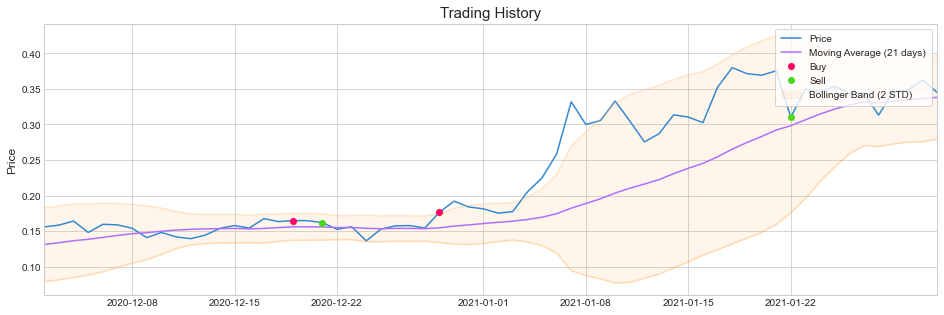

In [210]:
profit, trades = macd_trading(df.loc['2020-12':'2021-01'])

In [211]:
df.tail()

,Close,Prediction,MACD,Signal,Upper_band,Lower_band,MA21
Date,,,,,,,
2021-02-21 23:59:59,1.100520,0.954709,0.162134,0.144908,1.211663,0.326591,0.769127
2021-02-22 23:59:59,1.099151,1.051657,0.165147,0.148956,1.233648,0.370998,0.802323
2021-02-23 23:59:59,0.954709,1.079116,0.154102,0.149985,1.227162,0.427814,0.827488
2021-02-24 23:59:59,1.051657,1.241105,0.151426,0.150273,1.225912,0.487184,0.856548
2021-02-25 23:59:59,1.079116,1.324860,0.149795,0.150178,1.215462,0.558401,0.886932


In [212]:
def bb_trading(stock, budget=15000, u=0.03, l=0.03, show_graph=True, show_return=True):
    
    money = budget
    stock = stock.reset_index()
    net = []
    for i in range(len(stock)):
        today = stock.iloc[i]
        
        # Buy
        if (today.Close < today.MA21) and (abs(1 - today.Close / today.Lower_band) < u):
            if money > 0:
                stock_amt = int(money / today.Close)
                money = 0
                net.append([today.Date, today.Close, 1, stock_amt * today.Close])

        # Sell        
        if (today.Close > today.MA21) and (abs(1 - today.Upper_band / today.Close) < l):
            if money == 0:
                money = stock_amt * today.Close
                stock_amt = 0
                net.append([today.Date, today.Close, 0, money])
        
    profit = net[-1][3] - budget
    
    if show_return == True:
        print('Number of Trades: {}'.format(len(net)))
        print('Time Frame: {} days'.format((net[-1][0] - net[0][0]).days))
        print('Profit: ${:.2f} | {}%'.format(profit, round(profit/budget*100, 2)))

    if show_graph == True:
        trading_history(stock.set_index('Date'), net)

    return profit, net

Number of Trades: 2
Time Frame: 5 days
Profit: $4436.39 | 29.58%


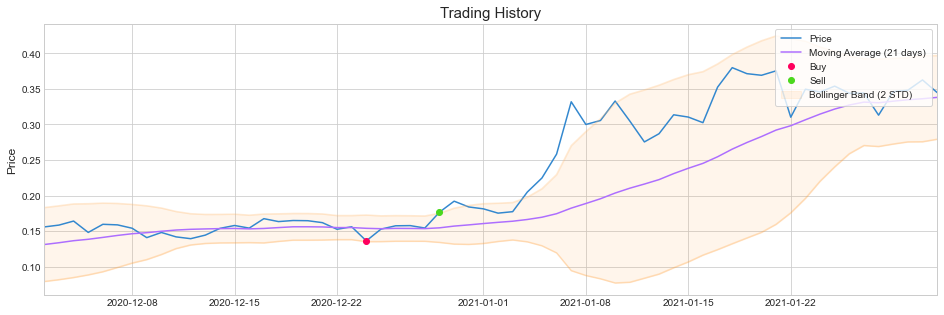

In [220]:
profit, trades = bb_trading(df.loc['2020-12':'2021-01'], u=0.03, l=0.03)